In [1]:
!pip freeze

absl-py==2.1.0
aiohappyeyeballs==2.4.3
aiohttp==3.10.10
aiosignal==1.3.1
alembic==1.14.0
antlr4-python3-runtime==4.9.3
anyio==4.2.0
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asteroid-filterbanks==0.4.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
audioread==3.0.1
autograd==1.7.0
autoray==0.7.0
Babel==2.14.0
beautifulsoup4==4.12.3
bleach==6.1.0
blinker==1.8.2
CacheControl==0.14.0
cachetools==5.3.2
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
colorama==0.4.6
colorlog==6.9.0
comm==0.2.1
contourpy==1.2.0
cryptography==43.0.0
cycler==0.12.1
Cython==3.0.11
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
docopt==0.6.2
einops==0.8.0
et_xmlfile==2.0.0
exceptiongroup==1.2.0
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
firebase-admin==6.5.0
Flask==3.0.3
flatbuffers==23.5.26
fonttools==4.48.1
fqdn==1.5.1
frozendict==2.4.6
frozenlist==1.5.0
fsspec==2024.2.0
gast==0.4.0
google-api-core

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

# Replace this to use Noisy QLSTM
# from QLSTM_Noisy import SequenceDataset
from QLSTMv1 import SequenceDataset

import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [ ]:
df = pd.read_csv('hcl_combined.csv')

In [ ]:
columns = ['Open Price', 'High Price', 'Low Price', 'Close Price','feature1','feature2','feature3','feature4','feature5']

In [ ]:
data = df.filter(columns)
dataset = data.values

In [ ]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [ ]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close Price'

In [ ]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [ ]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [ ]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 9])
Target shape: torch.Size([1])


In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output.cpu()

In [ ]:
from QLSTMv1 import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features),
    hidden_units=num_hidden_units,
    n_qubits=7,
    n_qlayers=1
).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [ ]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 327


In [21]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
# start = time.time()
# test_loss = test_model(test_loader, Qmodel, loss_function)
# end = time.time()
# print("Execution time", end - start)
# quantum_loss_test.append(test_loss)

num_epochs = 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Epoch 0
---------
Train loss: 0.03318206492380219
Test loss: 0.007194885257263963
Execution time 193.2568714618683
Epoch 1
---------
Train loss: 0.0017869951924427108
Test loss: 0.002434103247378286
Execution time 190.57463383674622
Epoch 2
---------
Train loss: 0.0021537655225352167
Test loss: 0.007568331583056887
Execution time 190.33815097808838
Epoch 3
---------
Train loss: 0.0027437095039235886
Test loss: 0.003031292001646892
Execution time 191.82515692710876
Epoch 4
---------
Train loss: 0.0018234283830840764
Test loss: 0.005589576838560467
Execution time 189.0535809993744
Epoch 5
---------
Train loss: 0.0009620576049177884
Test loss: 0.0012442817870168244
Execution time 187.84123849868774
Epoch 6
---------
Train loss: 0.0013576189730753383
Test loss: 0.0026165442354918137
Execution time 188.59812450408936
Epoch 7
---------
Train loss: 0.0014576168173463626
Test loss: 0.003556980056720806
Execution time 188.39315915107727
Epoch 8
---------
Train loss: 0.00

In [22]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).cpu().numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).cpu().numpy()

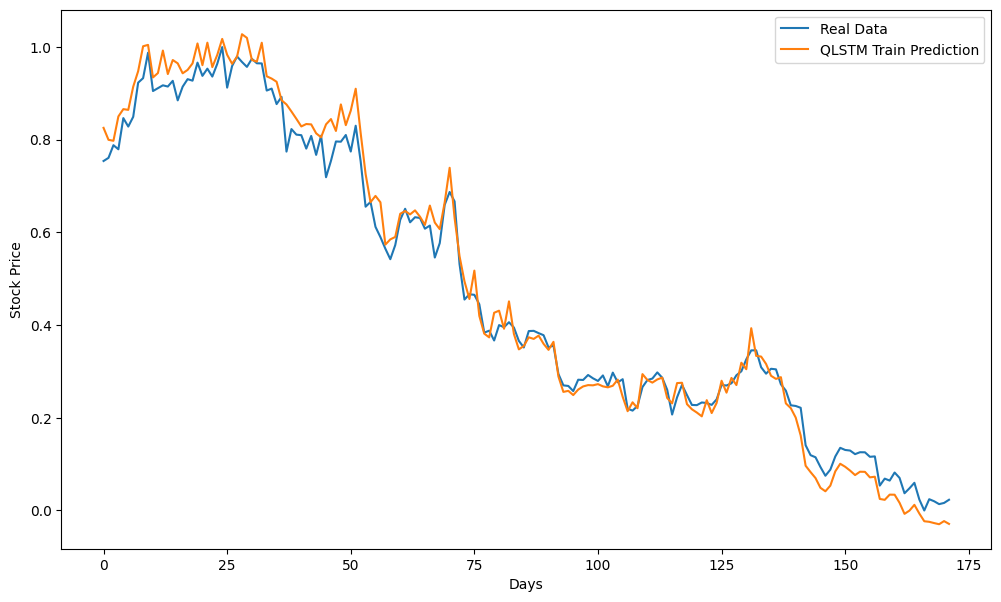

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train["Close Price"], label = "Real Data")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "QLSTM Train Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

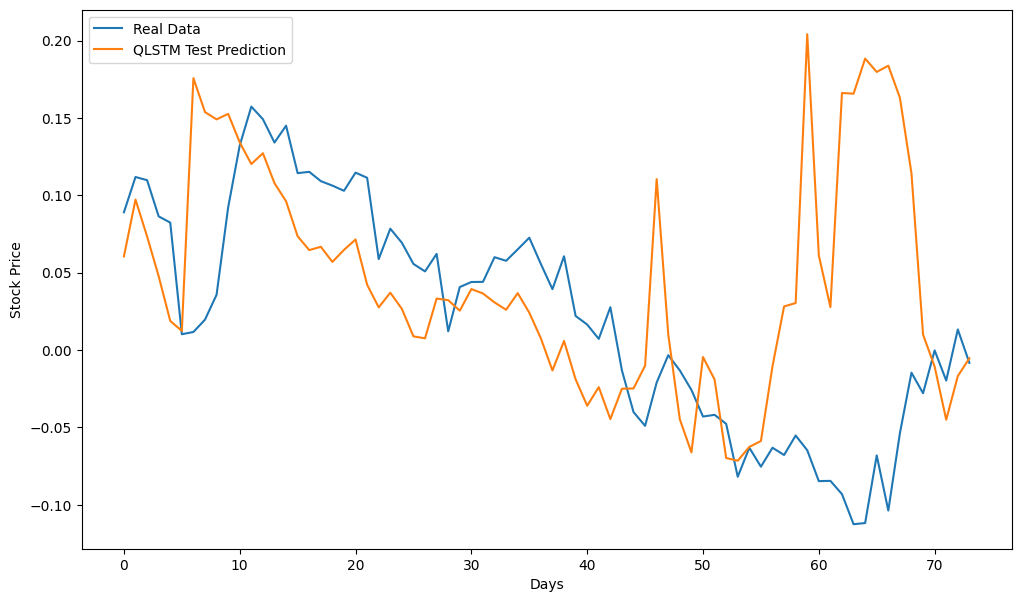

In [26]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["Close Price"], label = "Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label = "QLSTM Test Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

In [27]:
# Calculate the RMSE for the train and test data
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(df_train["Close Price"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["Close Price"], df_test["Model Forecast"]))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.03813780841560878
Test RMSE: 0.0986714861373125


In [28]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

train_accuracy = accuracy(df_train["Close Price"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Close Price"], df_test["Model Forecast"])
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 0.9883720930232558
Test accuracy: 0.8108108108108109


In [ ]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_Stock_Price_Model.pt")